# here we go

In [3]:
# imports and pre-definitions

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys

import numpy as np

import matplotlib.pyplot as plt

HOME_DIR = "/Users/oliver/Documents/p5control-bluefors-evaluation"
sys.path.append(HOME_DIR)

from utilities.corporate_design_colors_v4 import cmap, colors

from geometry import to_polygons
from geometry import annular_wedge_polygon

from geometry import regular_polygon
from geometry import circle
from geometry import rectangle
from geometry import square

from geometry import oblique_lattice
from geometry import regular_lattice

from geometry import platonic_tiles

from geometry import gaussian_ring
from geometry import radial_lobe

In [ ]:
from shapely import MultiPoint, MultiLineString

import numpy as np
from numpy.typing import NDArray


def pentagrid(n_lines: int = 10, a: float = 1.0) -> tuple[MultiPoint, MultiLineString]:
    # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection

    # parameter range
    alpha: NDArray[np.float64] = np.deg2rad([0, 36, 72, 108, 144], dtype="float64")
    n: NDArray[np.float64] = np.arange(-n_lines, n_lines + 1, 1, dtype="float64")
    m: int = 10 * n_lines + 5

    # all combinations of number of lines and angles
    alpha, n = np.meshgrid(alpha, n)
    alpha, n = np.ravel(alpha), np.ravel(n)

    # each and every pair of two lines
    i, j = np.indices((m, m))
    i, j = np.ravel(i), np.ravel(j)

    # lines connecting points A and B
    ax = a * (+n_lines * np.cos(alpha) - n * np.sin(alpha))
    ay = a * (+n_lines * np.sin(alpha) + n * np.cos(alpha))
    bx = a * (-n_lines * np.cos(alpha) - n * np.sin(alpha))
    by = a * (-n_lines * np.sin(alpha) + n * np.cos(alpha))

    # intersections of pair of lines
    x = (ax[i] * by[i] - ay[i] * bx[i]) * (ax[j] - bx[j]) - (ax[i] - bx[i]) * (
        ax[j] * by[j] - ay[j] * bx[j]
    )
    y = (ax[i] * by[i] - ay[i] * bx[i]) * (ay[j] - by[j]) - (ay[i] - by[i]) * (
        ax[j] * by[j] - ay[j] * bx[j]
    )
    norm = (ax[i] - bx[i]) * (ay[j] - by[j]) - (ay[i] - by[i]) * (ax[j] - bx[j])

    # applying denominator
    norm = np.where(norm <= 1e-9, np.nan, norm)
    x, y = x / norm, y / norm

    # omit intersections out of range
    mask = np.sqrt(x**2 + y**2) <= n_lines * a
    x, y = x[mask], y[mask]

    # generate Base Geometroies
    lines = MultiLineString(
        [((ix, iy), (jx, jy)) for ix, iy, jx, jy in zip(ax, ay, bx, by)]
    )
    points = MultiPoint([(i, j) for i, j in zip(x, y)])

    return points, lines

In [6]:
# test pentagrid
%matplotlib qt
from shapely.plotting import plot_line, plot_points
mp, mls = pentagrid(300)
plot_line(mls, add_points=False)
plot_points(mp, ms=1, color="red")

In [ ]:
from shapely.geometry import MultiLineString, LineString, Point
from shapely.strtree import STRtree
import numpy as np


def multilinestring_intersections(mls, tol=1e-9):
    """
    Given a Shapely MultiLineString (or list of LineStrings), return:
      - coords: np.ndarray (N,2) unique intersection coordinates
      - pairs: list of (i,j) index pairs of lines that intersect at that point
      - mapping: dict mapping coord (rounded tuple) -> list of (i,j) that produced it

    Handles Points, MultiPoints, GeometryCollections, and overlapping segments.
    """
    # Normalize input to list of LineStrings
    if isinstance(mls, MultiLineString):
        lines = list(mls.geoms)
    else:
        # assume an iterable of LineString-like
        lines = list(mls)

    # Build spatial index
    tree = STRtree(lines)
    n = len(lines)

    # helpers
    def extract_points_from_geom(g):
        """Return list of shapely Point objects extracted/derived from geometry g."""
        pts = []
        if g.is_empty:
            return pts
        t = g.geom_type
        if t == "Point":
            pts.append(g)
        elif t == "MultiPoint":
            pts.extend(list(g.geoms))
        elif t == "GeometryCollection":
            for sub in g.geoms:
                pts.extend(extract_points_from_geom(sub))
        elif t in ("LineString", "LinearRing"):
            # overlapping segment: take endpoints and midpoint as representatives
            coords = list(g.coords)
            if len(coords) >= 2:
                p0 = Point(coords[0])
                p1 = Point(coords[-1])
                pts.extend([p0, p1, g.representative_point()])
        elif t == "MultiLineString":
            for sub in g.geoms:
                pts.extend(extract_points_from_geom(sub))
        else:
            # fallback: try to get representative point
            try:
                rp = g.representative_point()
                pts.append(rp)
            except Exception:
                pass
        return pts

    found = {}  # map rounded coord -> set of (i,j)
    for i, Li in enumerate(lines):
        # query candidates that bbox-intersect Li
        candidates = tree.query(Li)
        for Lj in candidates:
            j = lines.index(Lj)
            if j <= i:
                continue  # avoid duplicates; only i < j
            try:
                inter = Li.intersection(Lj)
            except Exception:
                # defensive: skip problematic pair
                continue
            pts = extract_points_from_geom(inter)
            for p in pts:
                # round to avoid tiny fp duplicates
                key = (round(float(p.x), 9), round(float(p.y), 9))
                if key not in found:
                    found[key] = set()
                found[key].add((i, j))

    # build outputs
    coords = np.array(list(found.keys()), dtype=float)
    pairs = [list(s) for s in found.values()]
    mapping = {k: list(v) for k, v in found.items()}
    return coords, pairs, mapping


from shapely.geometry import MultiLineString

mls = MultiLineString(
    [
        [(0, 0), (2, 2)],
        [(0, 2), (2, 0)],
        [(1, 0), (1, 2)],
        [(0.5, 0.5), (1.5, 1.5)],  # overlapping segment with first
    ]
)

coords, pairs, mapping = multilinestring_intersections(mls)

print("Coordinates:\n", coords)
print("Pairs for each coordinate (in same order):\n", pairs)
# mapping gives which line-index pairs created each coordinate:
for coord_key, idx_pairs in mapping.items():
    print(coord_key, idx_pairs)

ValueError: np.int64(0) is not in list

In [9]:
import numpy as np
import matplotlib.pyplot as plt

golden_ratio = (np.sqrt(5) + 1) / 2


def pentagrid_points(n_lines=10, spacing=1.0):
    """
    Generate Penrose/pentagrid intersection points.

    Parameters
    ----------
    n_lines : int
        Number of lines per direction family (controls patch size)
    spacing : float
        Distance between neighboring lines

    Returns
    -------
    pts : (N,2) array
        Intersection coordinates
    """
    # 5 directions separated by 36°
    angles = np.deg2rad(np.arange(0, 180, 36))[:5]
    normals = np.stack((np.cos(angles), np.sin(angles)), axis=1)

    # integer offsets for each family
    ks = np.arange(-n_lines, n_lines + 1)

    pts = []
    lines = []
    # pick all pairs of grid families (i,j)
    for i in range(5):
        for j in range(i + 1, 5):
            n1, n2 = normals[i], normals[j]
            # matrix to solve [n1; n2]·r = [k1, k2]
            M = np.stack((n1, n2))
            det = np.linalg.det(M)
            if abs(det) < 1e-8:
                continue
            invM = np.linalg.inv(M)
            # intersect each line i(k1) with j(k2)
            for k1 in ks:
                for k2 in ks:
                    line = np.array([k1 * spacing, k2 * spacing])
                    r = invM @ line
                    pts.append(r)
                    lines.append(line)
    pts = np.unique(np.round(pts, 8), axis=0)
    lines = np.array(lines)
    return pts, lines


# --- generate and plot ---
pts, lines = pentagrid_points(n_lines=100, spacing=golden_ratio)  # golden spacing
plt.figure(figsize=(7, 7))
plt.scatter(pts[:, 0], pts[:, 1], s=1, color="steelblue")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.show()

([<matplotlib.lines.Line2D at 0x114be8f50>],
 array([[-8.09016994, -8.09016994],
        [-8.09016994, -6.47213595],
        [-8.09016994, -4.85410197],
        ...,
        [ 8.09016994,  4.85410197],
        [ 8.09016994,  6.47213595],
        [ 8.09016994,  8.09016994]], shape=(1210, 2)))

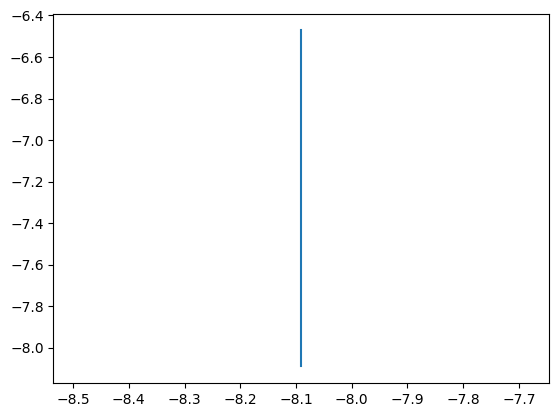

In [ ]:
plt.plot(lines[0, :], lines[1, :]), lines

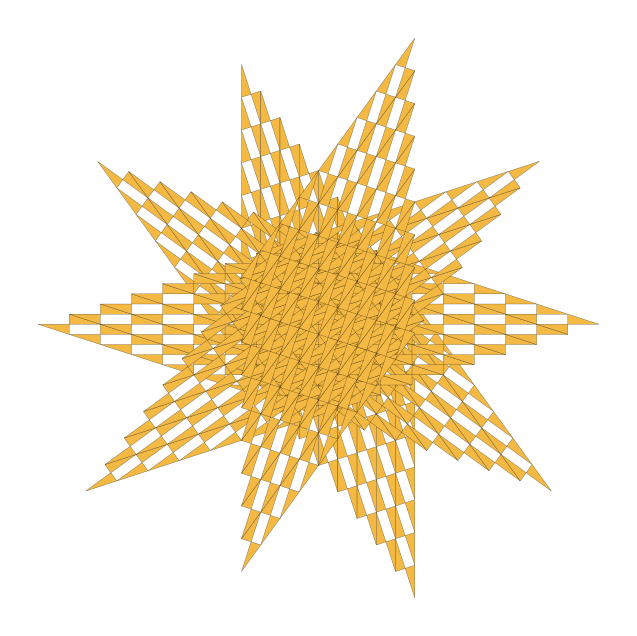

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi, sqrt

phi = (1 + sqrt(5)) / 2


def pentagrid_lines(n_lines=10, spacing=1.0):
    """Return normal vectors and line offsets for the five grids."""
    angles = np.deg2rad(np.arange(0, 180, 36))[:5]
    normals = np.stack((np.cos(angles), np.sin(angles)), axis=1)
    offsets = np.arange(-n_lines, n_lines + 1) * spacing
    return normals, offsets


def intersect_lines(n1, n2, k1, k2):
    """Intersection of two lines n1·r=k1, n2·r=k2."""
    M = np.stack((n1, n2))
    det = np.linalg.det(M)
    if abs(det) < 1e-8:
        return None
    return np.linalg.solve(M, np.array([k1, k2]))


def penrose_rhombi(n_lines=8, spacing=phi):
    """
    Generate Penrose rhombi via de Bruijn 5-grid construction.
    Returns a list of (4,2) arrays (the rhombi).
    """
    normals, offsets = pentagrid_lines(n_lines, spacing)
    rhombi = []
    # Each rhomb comes from adjacent grid families (i,i+1)
    for i in range(5):
        j = (i + 1) % 5
        for k1 in offsets:
            for k2 in offsets:
                # four corner intersections around the cell between lines k1/k1+1 and k2/k2+1
                pts = []
                for da in [0, 1]:
                    for db in [0, 1]:
                        p = intersect_lines(
                            normals[i], normals[j], k1 + da * spacing, k2 + db * spacing
                        )
                        if p is not None:
                            pts.append(p)
                if len(pts) == 4:
                    rhombi.append(np.array(pts))
    return rhombi


# --- generate rhombi and plot ---
rhombi = penrose_rhombi(n_lines=4, spacing=phi)

fig, ax = plt.subplots(figsize=(8, 8))
for r in rhombi:
    # classify thick vs thin by interior angle
    v0, v1, v2, v3 = r
    a = np.arccos(
        np.clip(
            np.dot(v1 - v0, v2 - v1)
            / (np.linalg.norm(v1 - v0) * np.linalg.norm(v2 - v1)),
            -1,
            1,
        )
    )
    color = "#f4b942" if a > np.deg2rad(54) else "#4682b4"
    poly = np.vstack([r, r[0]])
    ax.fill(poly[:, 0], poly[:, 1], color=color, edgecolor="k", linewidth=0.15)
ax.set_aspect("equal")
ax.axis("off")
plt.show()

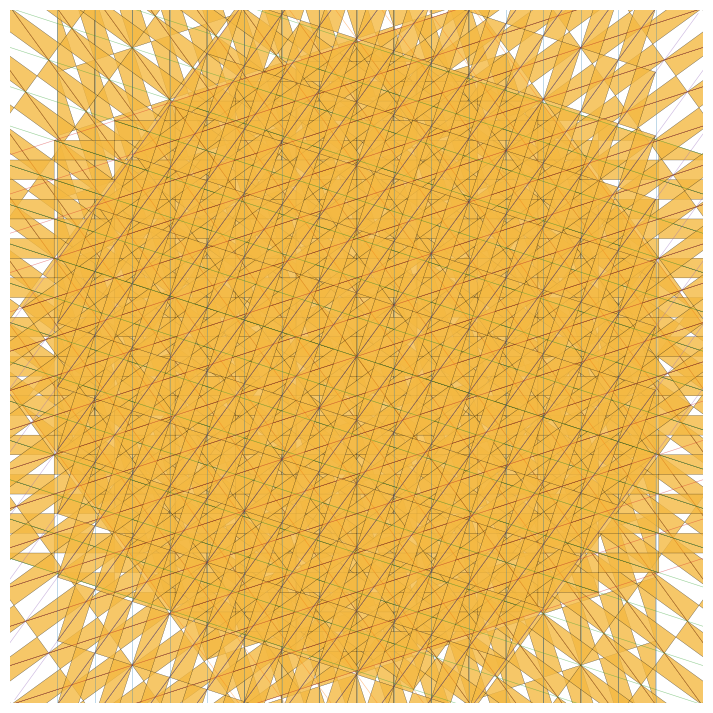

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, sqrt, pi

phi = (1 + sqrt(5)) / 2


def pentagrid_lines(n_lines=10, spacing=1.0):
    """Return normal vectors and line offsets for the five grids."""
    angles = np.deg2rad(np.arange(0, 180, 36))[:5]
    normals = np.stack((np.cos(angles), np.sin(angles)), axis=1)
    offsets = np.arange(-n_lines, n_lines + 1) * spacing
    return normals, offsets, angles


def intersect_lines(n1, n2, k1, k2):
    """Intersection of two lines n1·r=k1, n2·r=k2."""
    M = np.stack((n1, n2))
    det = np.linalg.det(M)
    if abs(det) < 1e-8:
        return None
    return np.linalg.solve(M, np.array([k1, k2]))


def penrose_rhombi(n_lines=8, spacing=phi):
    """Generate Penrose rhombi via de Bruijn 5-grid construction."""
    normals, offsets, _ = pentagrid_lines(n_lines, spacing)
    rhombi = []
    for i in range(5):
        j = (i + 1) % 5
        for k1 in offsets[:-1]:
            for k2 in offsets[:-1]:
                pts = []
                for da in [0, 1]:
                    for db in [0, 1]:
                        p = intersect_lines(
                            normals[i], normals[j], k1 + da * spacing, k2 + db * spacing
                        )
                        if p is not None:
                            pts.append(p)
                if len(pts) == 4:
                    rhombi.append((i, j, np.array(pts)))
    return rhombi


# --- generate rhombi and grids ---
n_lines = 8
spacing = phi
normals, offsets, angles = pentagrid_lines(n_lines, spacing)
rhombi = penrose_rhombi(n_lines, spacing)

# --- plotting ---
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_aspect("equal")
ax.axis("off")

# draw 5 grids
L = n_lines * spacing * 1.6
for i, (n, a) in enumerate(zip(normals, angles)):
    # direction vector (perpendicular to normal)
    t = np.array([-sin(a), cos(a)])
    for k in offsets:
        p0 = n * k
        line = np.stack((p0 - t * L, p0 + t * L))
        ax.plot(line[:, 0], line[:, 1], color=f"C{i}", lw=0.4, alpha=0.5)

# draw rhombi
for i, j, verts in rhombi:
    # classify thick vs thin
    v0, v1, v2, v3 = verts
    a = np.arccos(
        np.clip(
            np.dot(v1 - v0, v2 - v1)
            / (np.linalg.norm(v1 - v0) * np.linalg.norm(v2 - v1)),
            -1,
            1,
        )
    )
    color = "#f4b942" if a > np.deg2rad(54) else "#4682b4"  # thick/thin
    poly = np.vstack([verts, verts[0]])
    ax.fill(poly[:, 0], poly[:, 1], color=color, alpha=0.8, edgecolor="k", lw=0.2)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
plt.show()

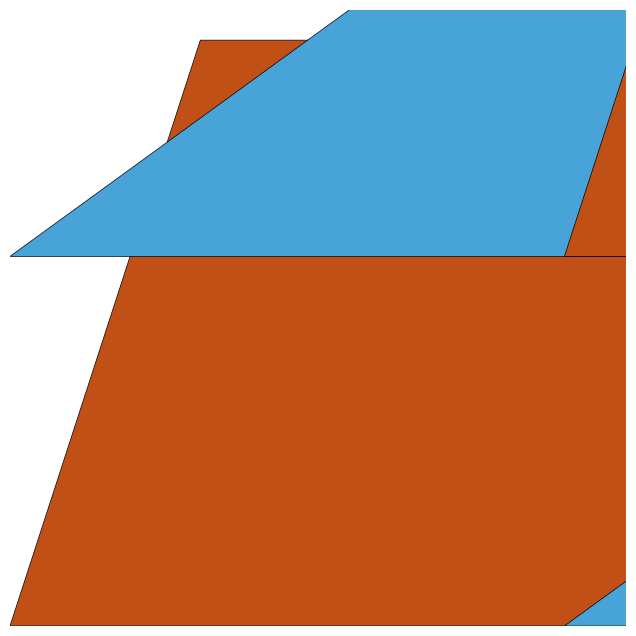

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def penrose_rhombus(thick=True, a=1.0):
    """
    Return coordinates for a Penrose rhombus (thick or thin).

    Parameters
    ----------
    thick : bool
        If True, returns the 'thick' rhombus (72°/108°).
        If False, returns the 'thin' rhombus (36°/144°).
    a : float
        Edge length.

    Returns
    -------
    np.ndarray
        Shape (4, 2), coordinates of the rhombus.
    """
    if thick:
        angle = np.deg2rad(72)
    else:
        angle = np.deg2rad(36)
    # Vertices of rhombus
    p0 = np.array([0, 0])
    p1 = np.array([a, 0])
    p2 = p1 + a * np.array([np.cos(angle), np.sin(angle)])
    p3 = a * np.array([np.cos(angle), np.sin(angle)])
    return np.array([p0, p1, p2, p3])


# Create plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.axis("off")

# Fill an area with alternating thick/thin rhombi
nx, ny = 10, 10
a = 1.0
for i in range(nx):
    for j in range(ny):
        thick = (i + j) % 2 == 0
        rhomb = penrose_rhombus(thick=thick, a=a)
        # Shift position
        shift = np.array([i * a * 0.9, j * a * 0.6])
        poly = Polygon(
            rhomb + shift,
            closed=True,
            edgecolor="k",
            facecolor="#c15017" if thick else "#48a4d8",
            lw=0.5,
        )
        ax.add_patch(poly)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def penrose_rhombi_tiling(n_points=4000, radius=5.0):
    """
    Generate Penrose P2 (rhombus) tiling via projection from 5D hypercubic lattice.
    """
    phi = (1 + np.sqrt(5)) / 2
    tau = 2 * np.pi / 5
    # 5 unit vectors spaced by 72°
    e = np.array([[np.cos(k * tau), np.sin(k * tau)] for k in range(5)])
    # integer combinations (points in Z^5 with limited range)
    rng = np.arange(-n_points // 10, n_points // 10)
    indices = np.stack(np.meshgrid(*([rng] * 5)), axis=-1).reshape(-1, 5)
    # project into 2D
    pts = indices @ e
    # select those near origin (window condition)
    mask = np.all((indices @ e.T) < phi, axis=1)
    pts = pts[mask]
    # keep only points within radius
    r = np.linalg.norm(pts, axis=1)
    pts = pts[r < radius]
    return pts


# ---- plot ----
pts = penrose_rhombi_tiling(radius=4)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.axis("off")

# plot thick and thin rhombi
phi = (1 + np.sqrt(5)) / 2
tau = 2 * np.pi / 5
dirs = np.array([[np.cos(k * tau), np.sin(k * tau)] for k in range(5)])

for i in range(len(dirs)):
    for j in range(i + 1, len(dirs)):
        # each intersection of 2 grids forms rhombi
        for p in pts:
            v0 = p
            v1 = p + dirs[i]
            v2 = p + dirs[j]
            v3 = v1 + dirs[j] - p
            # choose color by angle difference
            ang = abs(i - j)
            color = "#f6d743" if ang in (1, 4) else "#47b6f6"
            ax.add_patch(
                Polygon(
                    [v0, v1, v3, v2],
                    closed=True,
                    facecolor=color,
                    edgecolor="k",
                    lw=0.2,
                )
            )

plt.show()

MemoryError: Unable to allocate 2.33 PiB for an array with shape (800, 800, 800, 800, 800) and data type int64

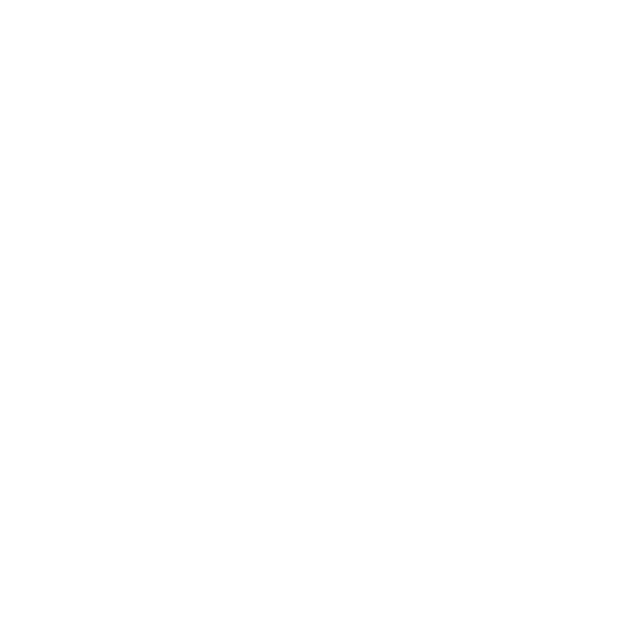

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


def penrose_tiling_projection(n=8000, radius=5.0):
    """Generate approximate Penrose rhombus tiling by 5D projection sampling."""
    phi = (1 + np.sqrt(5)) / 2
    tau = 2 * np.pi / 5
    # 5 directions at 72° steps
    e = np.array([[np.cos(k * tau), np.sin(k * tau)] for k in range(5)])

    # Random integer lattice points in 5D (smallish range)
    N = int(np.sqrt(n))
    pts5d = np.random.randint(-N, N, (n, 5))
    # 2D projection
    pts2d = pts5d @ e

    # Accept points near origin (window condition)
    mask = np.linalg.norm(pts5d, axis=1) < N * 0.8
    pts2d = pts2d[mask]
    r = np.linalg.norm(pts2d, axis=1)
    pts2d = pts2d[r < radius]
    return pts2d


# ---- plot ----
pts = penrose_tiling_projection(radius=6, n=20000)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.axis("off")

phi = (1 + np.sqrt(5)) / 2
tau = 2 * np.pi / 5
dirs = np.array([[np.cos(k * tau), np.sin(k * tau)] for k in range(5)])

# Draw small rhombi at projected points
for i, p in enumerate(pts):
    # choose random orientation
    i1, i2 = np.random.choice(5, 2, replace=False)
    v1, v2 = dirs[i1], dirs[i2]
    v0 = p
    v3 = p + 0.2 * (v1 + v2)
    v1 = p + 0.2 * v1
    v2 = p + 0.2 * v2
    ang = abs(i1 - i2)
    color = "#f6d743" if ang in (1, 4) else "#47b6f6"
    ax.add_patch(
        Polygon(
            [v0, v1, v3, v2], closed=True, facecolor=color, edgecolor="none", alpha=0.8
        )
    )

plt.show()

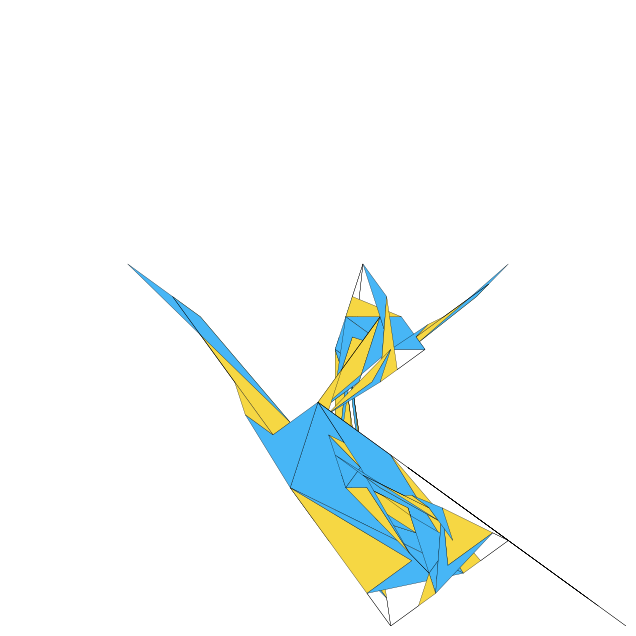

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

phi = (1 + np.sqrt(5)) / 2


def rotate(v, angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.dot(v, np.array([[c, -s], [s, c]]))


def deflate(tiles, n_steps=4):
    """Recursively subdivide Penrose rhombi."""
    new_tiles = []
    for _ in range(n_steps):
        next_tiles = []
        for ttype, A, B, C, D in tiles:
            if ttype == "thick":
                E = A + (B - A) / phi
                F = A + (D - A) / phi
                next_tiles += [
                    ("thick", C, D, F, E),
                    ("thin", E, F, B, C),
                ]
            else:  # thin
                E = B + (A - B) / phi
                F = B + (C - B) / phi
                next_tiles += [
                    ("thin", F, C, D, A),
                    ("thick", E, F, A, B),
                ]
        tiles = next_tiles
    return tiles


def initial_rhombus():
    """Start with one thick rhombus."""
    a = np.array([0.0, 0.0])
    b = np.array([1.0, 0.0])
    angle = np.deg2rad(36)
    c = b + rotate(a - b, angle)
    d = a + rotate(b - a, -angle)
    return [("thick", a, b, c, d)]


# ---- generate tiling ----
tiles = deflate(initial_rhombus(), n_steps=6)

# ---- plot ----
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.axis("off")

for ttype, A, B, C, D in tiles:
    color = "#f6d743" if ttype == "thick" else "#47b6f6"
    poly = Polygon([A, B, C, D], closed=True, facecolor=color, edgecolor="k", lw=0.2)
    ax.add_patch(poly)

plt.show()

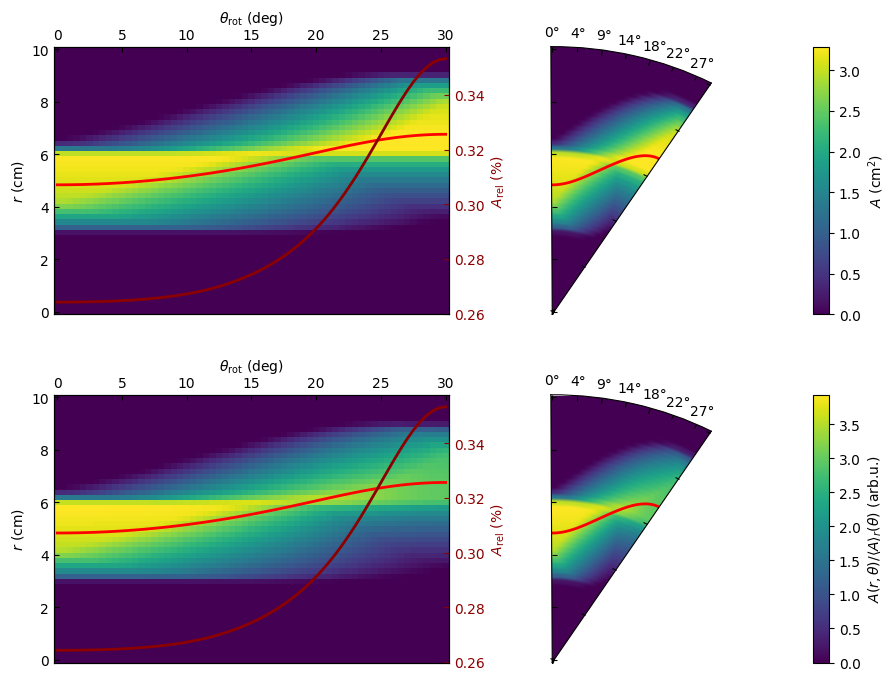

In [228]:
# show analysis results

fig = plt.figure(0, figsize=(10, 8))
gs = fig.add_gridspec(
    2, 3, height_ratios=[4, 4], width_ratios=[5, 4, 0.2], hspace=0.3, wspace=0.1
)

ax1_kar = fig.add_subplot(gs[0, 0])
ax1_rad = fig.add_subplot(gs[0, 1], projection="polar")
ax1_clb = fig.add_subplot(gs[0, 2])

ax2_kar = fig.add_subplot(gs[1, 0])
ax2_rad = fig.add_subplot(gs[1, 1], projection="polar")
ax2_clb = fig.add_subplot(gs[1, 2])

cmap1 = "viridis"  # cmap(color="seeblau", inverse=True)
cmap2 = "viridis"  # cmap(color="seegrün", inverse=True)

color_com = "red"  # colors(2)
color_area = "darkred"  # colors(3)

im1 = ax1_kar.imshow(
    A_r,
    extent=ext_deg,
    origin="lower",
    aspect="auto",
    cmap=cmap1,
)
im1 = ax1_rad.imshow(
    A_r,
    extent=ext_rad,
    origin="lower",
    aspect="auto",
    cmap=cmap1,
)
clb1 = fig.colorbar(im1, cax=ax1_clb)

im2 = ax2_kar.imshow(
    N_r,
    extent=ext_deg,
    origin="lower",
    aspect="auto",
    cmap=cmap2,
)
im2 = ax2_rad.imshow(
    N_r,
    extent=ext_rad,
    origin="lower",
    aspect="auto",
    cmap=cmap2,
)
clb2 = fig.colorbar(im2, cax=ax2_clb)

for ax in [ax1_kar, ax1_rad, ax2_kar, ax2_rad]:
    ax.tick_params(direction="in", left=True, right=True, top=True, bottom=True)

for ax in [ax1_rad, ax2_rad]:
    ax.plot(radians, r_com, lw=2, color=color_com)
    ax.set_xlim((ext_rad[0], ext_rad[1]))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(False)
    ax.set_yticklabels([])

for ax in [ax1_kar, ax2_kar]:
    ax.plot(degrees, r_com, lw=2, color=color_com)
    ax.set_xlabel("$\\theta_\\mathrm{rot}$ (deg)")
    ax.set_ylabel("$r$ (cm)")
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax2 = ax.twinx()
    ax2.plot(degrees, A_rel, lw=2, color=color_area)
    ax2.tick_params(
        direction="in",
        left=False,
        right=True,
        top=True,
        bottom=True,
        color=color_area,
        labelcolor=color_area,
    )
    ax2.set_ylabel("$A_\\mathrm{rel}$ (%)", color=color_area)

clb1.set_label("$A$ (cm$^2$)")
clb2.set_label("$A(r, \\theta) / \\langle A\\rangle_r(\\theta)$ (arb.u.)")